# 🧹 Forecasting Migration Flows — Data Preparation & Cleaning

**Author:** _Golib Sanaev_  
**Date:** _2025-09-23_  
**Last Updated:** _2025-10-08_  
**Project:** Forecasting Migration Flows with Machine Learning  

---

### 🎯 **Purpose**

This notebook focuses on preparing the datasets required for forecasting international migration flows.  
It includes the following main steps:
1. Setting up the working environment and dependencies.  
2. Separating World Bank and HDI data into **country-level** and **aggregate-level** subsets.  
3. Performing **data availability checks** and **missing value analysis**.  
4. Cleaning and imputing missing values for country and aggregate datasets.  
5. Exporting final cleaned datasets for downstream analysis and modeling.  

---

## 📑 Table of Contents

1. [Setup](#1-setup)  
2. [Separate Countries and Aggregates](#2-separate-countries-and-aggregates)  
 2.1. [Save Separate Datasets](#21-save-separate-datasets)  
3. [Load Cleaned Datasets for Analysis](#3-load-cleaned-datasets-for-analysis)  
4. [Data Availability and Completeness](#4-data-availability-and-completeness)  
 4.1. [Utility Functions](#41-utility-functions)  
 4.2. [Data Cleaning and Imputation for Countries](#42-data-cleaning-and-imputation-for-countries)  
 4.3. [Data Cleaning and Imputation for Aggregates](#43-data-cleaning-and-imputation-for-aggregates)  
 4.4. [Final Checks and Export](#44-final-checks-and-export)


## 1. Setup

- Import Required Libraries.  
- Setting dataset path.  

---

In [1]:
# Import necessary libraries
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
plt.rcParams.update({"figure.figsize": (10, 4), "figure.dpi": 120})

# Primary dataset path
DATA_PATH = Path("../data/processed/wdi_hdr.csv")
fallback = Path("/mnt/data/wdi_hdr.csv")

if not DATA_PATH.exists() and fallback.exists():
    DATA_PATH = fallback
    print(f"Using fallback path: {DATA_PATH}")
else:
    print(f"Using data path: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()

Using data path: ../data/processed/wdi_hdr.csv
Loaded shape: (9310, 19)


,Country Name,Country Code,year,pop_density,mobile_subs,exports_gdp,imports_gdp,gdp_growth,gdp_per_capita,under5_mortality,unemployment,net_migration,adol_fertility,life_expectancy,fertility_rate,pop_growth,population,urban_pop_growth,hdi
0,Afghanistan,AFG,1990,18.468424,0.0,NaN,NaN,NaN,NaN,180.7,NaN,-458737.0,139.376,45.118,7.576,1.434588,12045660.0,1.855712,0.285
1,Afghanistan,AFG,1991,18.764667,0.0,NaN,NaN,NaN,NaN,174.4,8.070,32782.0,145.383,45.521,7.631,1.591326,12238879.0,2.010729,0.291
2,Afghanistan,AFG,1992,20.359343,0.0,NaN,NaN,NaN,NaN,168.5,8.011,1197329.0,147.499,46.569,7.703,8.156419,13278974.0,8.574058,0.301
3,Afghanistan,AFG,1993,22.910893,0.0,NaN,NaN,NaN,NaN,163.0,7.888,1149684.0,149.461,51.021,7.761,11.807259,14943172.0,12.223160,0.311
4,Afghanistan,AFG,1994,24.915741,0.0,NaN,NaN,NaN,NaN,157.7,7.822,315206.0,156.835,50.969,7.767,8.388730,16250794.0,8.807544,0.305


## 2. Separate Countries and Aggregates

- Filter the raw dataset into:
  - `countries_only.csv`  
  - `aggregates_only.csv`  
- Save both processed files into `../data/processed/`

---

In [2]:
# Identify WDI aggregate vs. country entries based on keywords 

AGG_KEYWORDS = [
    "income", "countries", "world", "union", "region", "states",
    "area", "members", "bank", "monetary", "zone",
    "africa", "asia", "america", "europe", "latin", "sub-saharan",
    "middle east", "north", "south", "central",
    "develop", "fragile", "caribbean", "pacific",
    "early-demographic dividend", "late-demographic dividend",
    "post-demographic dividend", "pre-demographic dividend",
    "ibrd only", "ida & ibrd total", "ida blend",
    "ida only", "ida total"
]

EXCEPTIONS = {
    "american samoa",
    "central african republic",
    "south africa",
    "north macedonia",
    "south sudan",
    "united states",
    "korea, rep.",
    "korea, dem. people's rep.",
    "dominican republic",
    "czechia",
    "west bank and gaza",
    "british virgin islands",
    "cayman islands",
    "channel islands"
}

def is_aggregate(name: str) -> bool:
    """Return True if the entity name corresponds to an aggregate or regional group."""
    if not isinstance(name, str):
        return False
    low = name.lower().strip()
    if low in EXCEPTIONS:
        return False
    return any(k in low for k in AGG_KEYWORDS)


# Apply function and create classification flag
if "Country Name" in df.columns:
    df["is_aggregate"] = df["Country Name"].apply(is_aggregate)

# Summarize results
agg_counts = df["is_aggregate"].value_counts(dropna=False)

countries = (
    df.loc[~df["is_aggregate"], "Country Name"]
      .drop_duplicates().sort_values().to_list()
)
aggregates = (
    df.loc[df["is_aggregate"], "Country Name"]
      .drop_duplicates().sort_values().to_list()
)

print(f"\nNumber of countries: {len(countries)}")
print(f"Number of aggregates: {len(aggregates)}")



Number of countries: 217
Number of aggregates: 49


### 2.1 Save Separate Datasets

In [3]:
# Split into countries and aggregates
countries_df = df.loc[~df["is_aggregate"]].copy()
aggregates_df = df.loc[df["is_aggregate"]].copy()

# Drop the helper column before saving
for d in [countries_df, aggregates_df]:
    if "is_aggregate" in d.columns:
        d.drop(columns="is_aggregate", inplace=True)

# Save processed datasets 
countries_df.to_csv("../data/processed/countries_only.csv", index=False)
aggregates_df.to_csv("../data/processed/aggregates_only.csv", index=False)

print("\nSaved cleaned datasets:")
print("  • countries_only.csv")
print("  • aggregates_only.csv")



Saved cleaned datasets:
  • countries_only.csv
  • aggregates_only.csv


## 3. Load Cleaned Datasets for Analysis

- Load previously saved country-only and aggregate-only datasets.  
- Confirm shapes, columns, and completeness.  
- Prepare for availability and completeness analysis.

---

In [4]:
# Use clean datasets for EDA
countries_df = pd.read_csv("../data/processed/countries_only.csv")
aggregates_df = pd.read_csv("../data/processed/aggregates_only.csv")

print("Countries-only shape:", countries_df.shape)
print("Aggregates shape:", aggregates_df.shape)

df_country = countries_df.copy()  # Work primarily with country-level data
df_agg = aggregates_df.copy()

Countries-only shape: (7595, 19)
Aggregates shape: (1715, 19)


## 4. Data Availability and Completeness

### 4.1 Utility Functions

Define reusable functions for:
- Missing value visualization (`summarize_missing`)  
- Entity filtering (`drop_empty_entities`)  
- Imputation by variable group (`impute_variables`)  

---

In [5]:
def summarize_missing(df, group_col=None, entity_label="Country"):
    """
    Print basic dataset shape, columns, and missing value summary.
    Optionally plot missingness by year for time-series data.
    """
    print(f"{entity_label}-level dataset shape:", df.shape)
    print("Columns:", list(df.columns))
    
    missing_summary = df.isna().sum().sort_values(ascending=False)
    print("\nMissing values per column:")
    print(missing_summary)

    if group_col == 'year':
        missing_by_year = df.groupby('year').apply(lambda x: x.isna().mean())
        plt.figure(figsize=(12, 6))
        sns.heatmap(missing_by_year.T, cmap='viridis', cbar_kws={'label':'% Missing'})
        plt.xlabel('Year')
        plt.ylabel('Indicator')
        plt.title(f'Missing Values per Indicator per Year ({entity_label}-level)')
        plt.show()

In [6]:
def drop_empty_entities(df, entity_col, indicators):
    """
    Drop entities (countries or aggregates) that have all missing values for any indicator.
    Returns a filtered DataFrame.
    """
    entities_to_drop = set()
    
    for col in indicators:
        no_data = df.groupby(entity_col)[col].apply(lambda x: x.isna().all())
        missing_entities = no_data[no_data].index.tolist()
        if missing_entities:
            print(f"{col}: {len(missing_entities)} {entity_col}s with no data")
            entities_to_drop.update(missing_entities)
    
    print(f"\nTotal {entity_col}s to drop (missing any indicator): {len(entities_to_drop)}")
    df = df[~df[entity_col].isin(entities_to_drop)].reset_index(drop=True)
    
    return df

In [7]:
def impute_variables(df, entity_col, time_series_vars, bounded_vars, trade_vars,
                     net_migration_var, population_density_var, remaining_missing=None):
    """
    Apply multi-stage imputation by variable group.
    """
    df = df.sort_values([entity_col, 'year']).reset_index(drop=True)
    
    # Time-series variables
    for col in time_series_vars:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method='linear'))
    
    # Bounded variables
    for col in bounded_vars:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method='linear'))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].clip(lower=0)
    
    # Trade variables
    for col in trade_vars:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method='linear'))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].clip(lower=0)
    
    # Net migration
    for col in net_migration_var:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method='linear'))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
    
    # Population density
    for col in population_density_var:
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.interpolate(method='linear'))
        df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
        df[col] = df[col].clip(lower=0)
    
    # Remaining missing
    if remaining_missing:
        for col, method in remaining_missing.items():
            if method == 'median':
                df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.median()))
            elif method == 'mean':
                df[col] = df.groupby(entity_col)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                raise ValueError(f"Unknown imputation method: {method}")
    
    print("\nRemaining missing values after imputation:")
    print(df.isna().sum())
    
    return df

### 4.2 Data Cleaning and Imputation for Countries

Country-level dataset shape: (7595, 19)
Columns: ['Country Name', 'Country Code', 'year', 'pop_density', 'mobile_subs', 'exports_gdp', 'imports_gdp', 'gdp_growth', 'gdp_per_capita', 'under5_mortality', 'unemployment', 'net_migration', 'adol_fertility', 'life_expectancy', 'fertility_rate', 'pop_growth', 'population', 'urban_pop_growth', 'hdi']

Missing values per column:
hdi                 1655
exports_gdp         1623
imports_gdp         1623
unemployment        1246
under5_mortality     931
mobile_subs          737
gdp_per_capita       562
gdp_growth           532
pop_density          499
adol_fertility       251
life_expectancy      251
fertility_rate       251
urban_pop_growth     107
pop_growth            38
net_migration         35
population            35
Country Code           0
year                   0
Country Name           0
dtype: int64


/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_12143/3234737814.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_year = df.groupby('year').apply(lambda x: x.isna().mean())


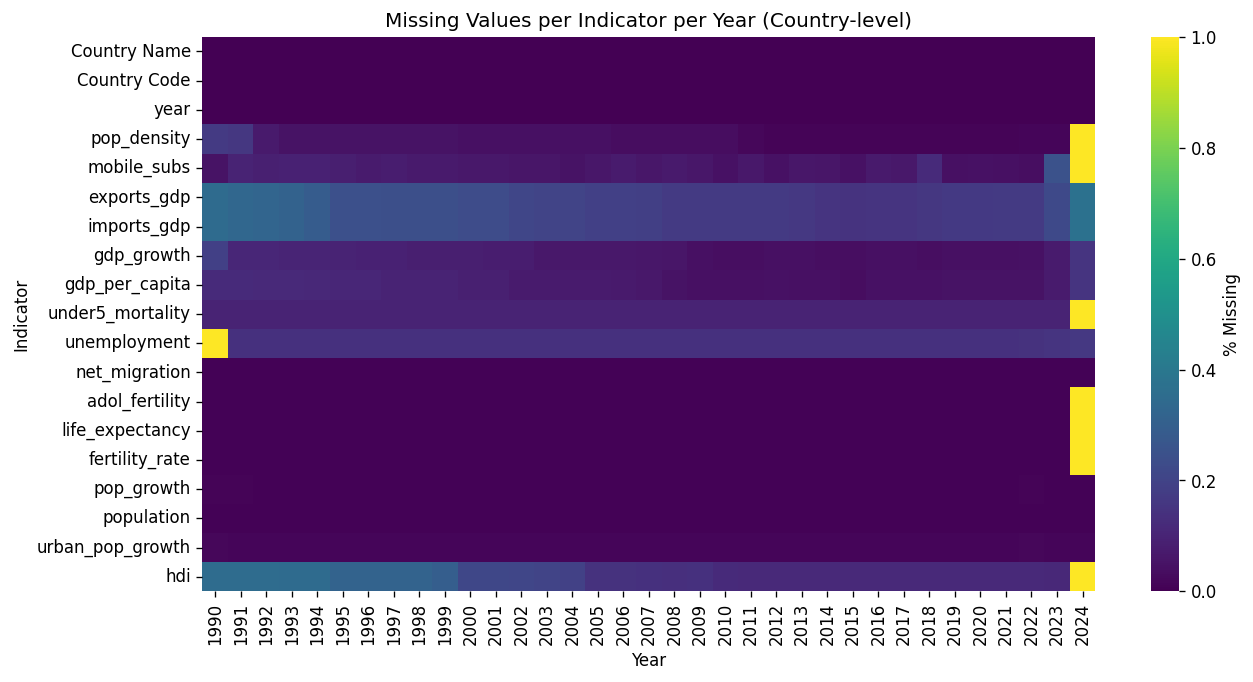

gdp_growth: 4 Country Names with no data
gdp_per_capita: 6 Country Names with no data
pop_growth: 1 Country Names with no data
urban_pop_growth: 3 Country Names with no data
adol_fertility: 1 Country Names with no data
fertility_rate: 1 Country Names with no data
life_expectancy: 1 Country Names with no data
mobile_subs: 4 Country Names with no data
under5_mortality: 21 Country Names with no data
hdi: 24 Country Names with no data
exports_gdp: 25 Country Names with no data
imports_gdp: 25 Country Names with no data
net_migration: 1 Country Names with no data
pop_density: 2 Country Names with no data
unemployment: 30 Country Names with no data

Total Country Names to drop (missing any indicator): 49

Remaining missing values after imputation:
Country Name        0
Country Code        0
year                0
pop_density         0
mobile_subs         0
exports_gdp         0
imports_gdp         0
gdp_growth          0
gdp_per_capita      0
under5_mortality    0
unemployment        0
net_mi

In [8]:
# Define variable groups
time_series_vars = ['gdp_growth', 'gdp_per_capita', 'pop_growth', 'urban_pop_growth']
bounded_vars = ['adol_fertility', 'fertility_rate', 'life_expectancy', 'mobile_subs', 'under5_mortality', 'hdi']
trade_vars = ['exports_gdp', 'imports_gdp']
net_migration_var = ['net_migration']
population_density_var = ['pop_density']
remaining_missing = {
    'gdp_growth': 'median',
    'gdp_per_capita': 'median',
    'unemployment': 'median',
    'pop_growth': 'median',
    'urban_pop_growth': 'median'
}

# Step 1: Inspect and visualize missingness
summarize_missing(df_country, group_col='year', entity_label="Country")

# Step 2: Drop countries missing any entire indicator
df_country = drop_empty_entities(
    df_country, 
    'Country Name', 
    indicators=time_series_vars + bounded_vars + trade_vars +
    net_migration_var + population_density_var + ['unemployment']
)

# Step 3: Impute missing values
df_country = impute_variables(
    df_country, 
    'Country Name', 
    time_series_vars, 
    bounded_vars, 
    trade_vars,
    net_migration_var, 
    population_density_var, 
    remaining_missing
)

# Step 4: Drop 2024 due to incompleteness
df_country = df_country[df_country['year'] < 2024].reset_index(drop=True)
print(f"Final shape after dropping 2024: {df_country.shape}")

### 4.3 Data Cleaning and Imputation for Aggregates

Dropped 'hdi' column from df_agg (not applicable for aggregates).
Country-level dataset shape: (1715, 18)
Columns: ['Country Name', 'Country Code', 'year', 'pop_density', 'mobile_subs', 'exports_gdp', 'imports_gdp', 'gdp_growth', 'gdp_per_capita', 'under5_mortality', 'unemployment', 'net_migration', 'adol_fertility', 'life_expectancy', 'fertility_rate', 'pop_growth', 'population', 'urban_pop_growth']

Missing values per column:
exports_gdp         188
mobile_subs         156
imports_gdp         101
pop_density          98
under5_mortality     83
unemployment         83
life_expectancy      49
fertility_rate       49
adol_fertility       49
gdp_growth           16
gdp_per_capita       14
population            0
pop_growth            0
Country Name          0
net_migration         0
Country Code          0
year                  0
urban_pop_growth      0
dtype: int64


/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_12143/3234737814.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_year = df.groupby('year').apply(lambda x: x.isna().mean())


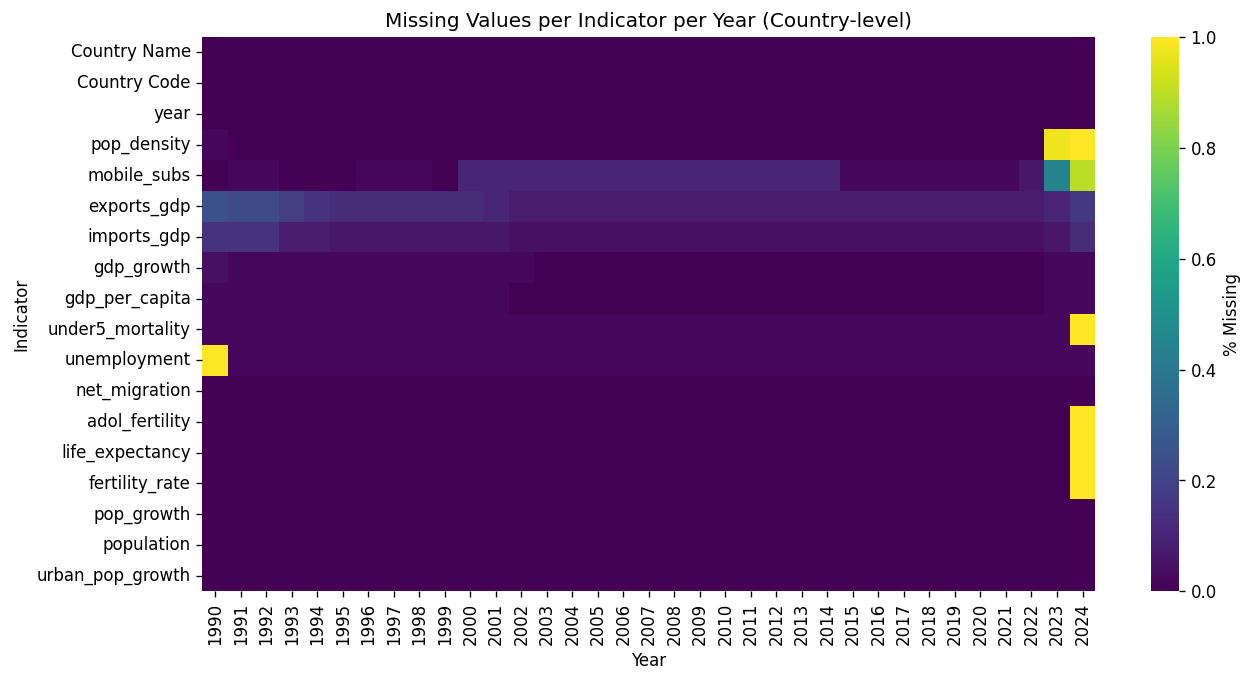

under5_mortality: 1 Country Names with no data
exports_gdp: 4 Country Names with no data
imports_gdp: 2 Country Names with no data
unemployment: 1 Country Names with no data

Total Country Names to drop (missing any indicator): 5

Remaining missing values after imputation:
Country Name        0
Country Code        0
year                0
pop_density         0
mobile_subs         0
exports_gdp         0
imports_gdp         0
gdp_growth          0
gdp_per_capita      0
under5_mortality    0
unemployment        0
net_migration       0
adol_fertility      0
life_expectancy     0
fertility_rate      0
pop_growth          0
population          0
urban_pop_growth    0
dtype: int64
Final shape after dropping 2024: (1496, 18)


In [9]:
# Modified bounded_vars
# Variable groups (HDI omitted — not available for aggregates)
bounded_vars = ['adol_fertility', 'fertility_rate', 'life_expectancy', 'mobile_subs', 'under5_mortality']

# Drop HDI from aggregates (not applicable at regional level)
if 'hdi' in df_agg.columns:
    df_agg = df_agg.drop(columns='hdi')
    print("Dropped 'hdi' column from df_agg (not applicable for aggregates).")

# Step 1: Inspect and visualize missingness
summarize_missing(df_agg, group_col='year', entity_label="Country")

# Step 2: Drop countries missing any entire indicator
df_agg = drop_empty_entities(
    df_agg, 
    'Country Name', 
    indicators=time_series_vars + bounded_vars + trade_vars +
    net_migration_var + population_density_var + ['unemployment']
)

# Step 3: Impute missing values
df_agg = impute_variables(
    df_agg, 
    'Country Name', 
    time_series_vars, 
    bounded_vars, 
    trade_vars,
    net_migration_var, 
    population_density_var, 
    remaining_missing
)

# Step 4: Drop 2024 due to incompleteness
df_agg = df_agg[df_agg['year'] < 2024].reset_index(drop=True)
print(f"Final shape after dropping 2024: {df_agg.shape}")

### 4.4 Final Checks and Export

Before moving on to the EDA notebook, confirm that all missing values have been handled properly and export the final cleaned datasets for future use.

In [10]:
# Summary of dataset dimensions
df_country_num_countries = df_country['Country Name'].nunique()
df_agg_num_countries = df_agg['Country Name'].nunique()
num_years = df_country['year'].nunique()

print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Countries:  {df_country_num_countries}")
print(f"Aggregates: {df_agg_num_countries}")
print(f"Years:      {num_years}")
print(f"Expected rows: {df_country_num_countries * num_years:,}")
print(f"Actual rows:   {len(df_country):,}")
print("="*60)

# Define processed data directory
DATA_DIR = Path("../data/processed")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Check remaining missing values
print("\nRemaining missing values:")
print(f"Countries:  {df_country.isna().sum().sum()}")
print(f"Aggregates: {df_agg.isna().sum().sum()}")

# Save cleaned datasets
df_country.to_csv(DATA_DIR / "countries_clean.csv", index=False)
df_agg.to_csv(DATA_DIR / "aggregates_clean.csv", index=False)

print("\nCleaned datasets saved successfully to:")
for path in [DATA_DIR / "countries_clean.csv", DATA_DIR / "aggregates_clean.csv"]:
    if path.exists():
        print(f"{path.name} ({path.stat().st_size/1024:.1f} KB)")

DATASET SUMMARY
Countries:  168
Aggregates: 44
Years:      34
Expected rows: 5,712
Actual rows:   5,712

Remaining missing values:
Countries:  0
Aggregates: 0

Cleaned datasets saved successfully to:
countries_clean.csv (1187.4 KB)
aggregates_clean.csv (425.7 KB)
